In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import date, timedelta, datetime,timezone
import requests
import pandas
import pytz
from scipy.optimize import curve_fit

In [40]:
def get_time(last_tick = 1
            ):
    "start and end of the time for the fridge query"
    now = datetime.now(timezone.utc)
    last_tick = now - timedelta(hours=last_tick)

    formatted_now = now.strftime("%Y-%m-%dT%H:%M:%S")
    formatted_last_tick = last_tick.strftime("%Y-%m-%dT%H:%M:%S")
    return (formatted_last_tick, formatted_now)


def get_config(file_path
                   ):
    "Keep the password in the a separate place"
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.strip().split('=', 1)
                credentials[key.strip()] = value.strip()
    return credentials


get_url = lambda url,table_name,tick_info: (f'{url}'
                                            f'table={table_name}&'
                                            f'startDate={tick_info[0]}&'
                                            f'endDate={tick_info[1]}'
                                           )

def get_fridge_data(tick_info,
                    table_name = 'fridge',
                    credential_file = 'credentials.txt'
                   ):
    "get fridge data"

    config = get_config(credential_file)
     
    url = get_url(config['url'],
                  table_name,
                  tick_info)
    print(url)
    
    response = requests.get(url, auth=(config['username'], config['password']))    
    
    data = response.json()
    pd_df = pandas.DataFrame(data)
    pd_df['timestamp'] = pandas.to_datetime(pd_df['timestamp'], utc=True)
    pd_df['timestamp'] = pd_df['timestamp'].dt.tz_convert('America/Toronto')
    pd_df['timestamp_int'] = pd_df['timestamp'].astype('int64')
    pd_df['timestamp_s'] = pd_df['timestamp_int'] / 10**9
    pd_df['timestamp_h'] = pd_df['timestamp_s'] / 3600
    return pd_df

def get_step_index(I_array):
    "Find the indices beyond which the MC temperature changes."
    
    I_array = np.array(I_array)  # if it's not already
    diffs = I_array[1:] != I_array[:-1]
    index_list = np.where(diffs)[0].tolist()

    return index_list


def make_plot(data, step_index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3),dpi = 150)

    # Extract tick positions
    tick_positions = data['timestamp_h'].iloc[step_index].values
    tick_labels = data['timestamp'].iloc[step_index].dt.strftime('%m/%d-%H:%M')
    # tick_labels = [f"{x:.2f}" for x in tick_positions]  # Format as needed

    # Plot data
    ax[0].plot(data['timestamp_h'], data['I3'], c = 'black')
    ax[0].set_ylabel('MC-current [mA]')
    ax[0].set_xlabel('Time')
    ax[0].set_xticks(tick_positions)  # Set only desired ticks
    ax[0].set_xticklabels(tick_labels, rotation=90, ha='center')

    
    ax[1].plot(data['timestamp_h'], data['T3'], c = 'black')
    ax[1].set_ylabel('MC-temperature [mK]')
    ax[1].set_xlabel('Time')
    ax[1].set_xticks(tick_positions)  # Set only desired ticks
    ax[1].set_xticklabels(tick_labels, rotation=90, ha='center')

    # Add vertical lines
    for index in step_index:
        x = data['timestamp_h'].iloc[index]
        ax[0].axvline(x, linestyle=':', color='r')
        ax[1].axvline(x, linestyle=':', color='r')
    return fig, ax

pram_to_record = {'time': 'timestamp',
                  'Still current [mA]': 'I0',
                  'MC current [mA]': 'I3',
                  'MC [mK](RuOx)': 'T3',
                  'MC [mK](CMN)': 'T5',
                  'ST [mK]': 'T2',
                  'CP [mK]': 'T4',
                  '4K [mK]': 'T1',
                  'Flow [ml/min]': 'Flow',
                  'PCOMP [mBar]': 'Pc',
                  'ST P [mBar]': 'MG2',
                  '4He Dump [mBar]': 'P6',
                  '3He Dump [mBar]': 'P7'}


get_available_keys = lambda df, pram_to_record: {tag:key for tag, key in pram_to_record.items() if key in df}
get_row_data = lambda row, avialable_keys: {key: row[mapped_key] for key, mapped_key in avialable_keys.items()}

def get_info_matching_rows(df1,df2,mapping):
    'find rows that match between df1 and df2 and return their info'
    avialable_keys1 = get_available_keys(df1,mapping)
    queries = {}
    for index, row in df1.iterrows():
        queries[row['timestamp_int']] = get_row_data(row,avialable_keys1)

    avialable_keys2 = get_available_keys(df2,mapping)
    for time in queries:
        closest_index = df2['timestamp_int'].sub(time).abs().idxmin()
        closest_row = df2.loc[closest_index]
        info = get_row_data(closest_row,avialable_keys2)   
        queries[time] = queries[time] | info
        
    return queries

def get_temp_info(n_hour=10, mapping=pram_to_record):
    "organize the fridge information at times that should be recorded into a dictionary"
    
    time_array = get_time(n_hour)
    
    df1 = get_fridge_data(time_array, table_name='temp')
    df2 = get_fridge_data(time_array)
    
    step_index = get_step_index(df1['I3'])
    reduced_df1 = df1.iloc[step_index]
    
    queries = get_info_matching_rows(reduced_df1,df2,mapping)
    
    fig, ax = make_plot(df1, step_index)
    return queries
    
def save_to_text(queries,file_name = 'output_data.txt'):
    with open(file_name, "w") as f:
        for i in queries.values():
            # Convert Timestamp to string for readability
            time_str = i['time'].strftime("%Y-%m-%d %H:%M:%S %Z")
            f.write(f"Time: {time_str}\n")
            for key, value in i.items():
                if key != 'time':
                    f.write(f"-- {key}: {value}\n")
            f.write("\n") 


https://scdms-monitor.tes-uoft.com/snolab/api/query?table=temp&startDate=2025-04-18T02:27:57&endDate=2025-04-18T20:27:57
https://scdms-monitor.tes-uoft.com/snolab/api/query?table=fridge&startDate=2025-04-18T02:27:57&endDate=2025-04-18T20:27:57


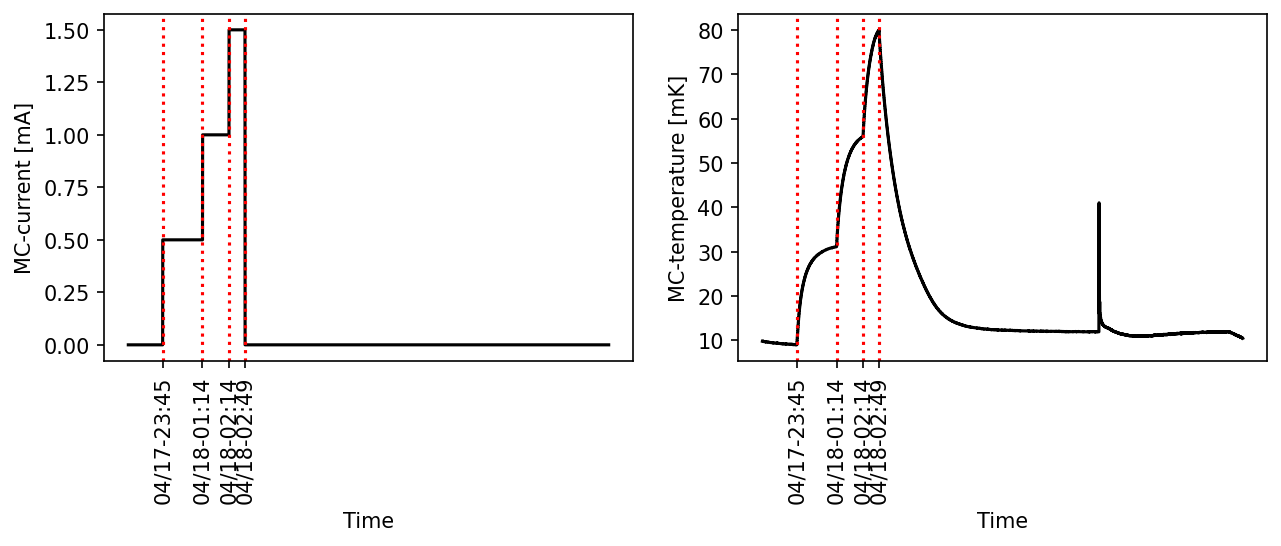

In [41]:
queries = get_temp_info(18)
save_to_text(queries,file_name = 'output_data.txt')

https://scdms-monitor.tes-uoft.com/snolab/api/query?table=temp&startDate=2025-04-18T03:45:13&endDate=2025-04-18T18:45:13
https://scdms-monitor.tes-uoft.com/snolab/api/query?table=fridge&startDate=2025-04-18T03:45:13&endDate=2025-04-18T18:45:13
a: 57.16
b: 21.03
c: -0.00
a: 81.66
b: 39.96
c: -0.00


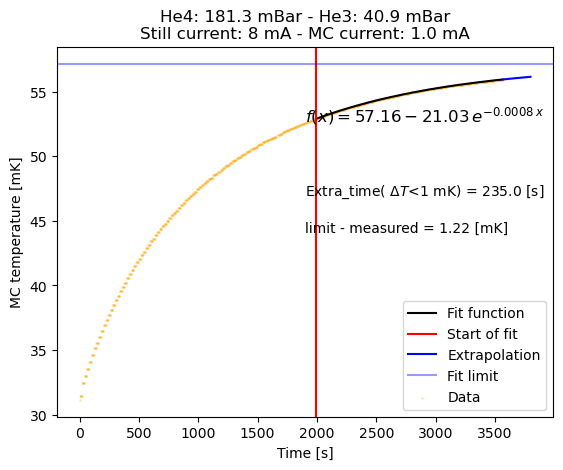

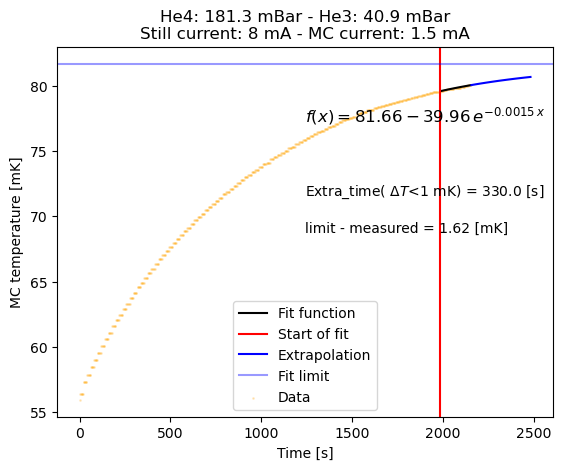

In [31]:
def get_temp_info(time_array):

    df1 = get_fridge_data(time_array, table_name='temp')
    df2 = get_fridge_data(time_array)

    step_index = get_step_index(df1['I3'])
    #Dropping the first element.
    reduced_df1 = df1.iloc[step_index[1:]]
    queries = get_info_matching_rows(reduced_df1,df2,pram_to_record)
    
    get_ranges = lambda array: [[i,j] for i , j in zip(array[:-1], array[1:])] 
    windows = [df1.iloc[i:j] for i, j  in get_ranges(step_index)]

    return {(entry['4He Dump [mBar]'],
             entry['3He Dump [mBar]'],
             entry['Still current [mA]'],
             entry['MC current [mA]']) : data for entry,data in zip(queries.values(), windows)}

get_xy = lambda window: ((window['timestamp_s']-window['timestamp_s'].min()).to_numpy(),window['T3'].to_numpy())

def saturating_exp(x, a, b, c):
    return a-b*np.exp(c*x)

def do_fit(fit_func, 
           x,
           y):
    # do fit
    params, pcov = curve_fit(fit_func, x, y,bounds=([0.001,0.001,-0.01],[max(y)+50,200,-0.00001]))    

    # plot the fit
    plt.figure(dpi =100)
    plt.plot(x,fit_func(x, *params), label = 'Fit function', c = 'k')
    # start of the fit
    plt.axvline(x[0],label='Start of fit',c = 'r')

    # show the temp difference
    temp_unc = params[0]-y[-1]
    ax = plt.gca()
    plt.text(
    0.5, 0.5,                            # x, y in axis fraction
    f'limit - measured = {temp_unc:.2f} [mK]',  # your text
    transform=ax.transAxes,             # <-- this is the key!
    )

    # find the amount of time needed to reach the limit
    y_max = y[-1]
    x_max = x[-1]
    temp_limit = 1
    x_extrapolation = []
    y_extrapolation = []
    while params[0]-y_max>temp_limit:
        x_max+=5
        y_max = saturating_exp(x_max,*params)
        x_extrapolation.append(x_max)
        y_extrapolation.append(y_max)
    extra_time = x_max-x[-1]
    plt.plot(x_extrapolation,y_extrapolation,c = 'b', label = 'Extrapolation')
    
    # show the amount of time needed to reach the limit
    plt.text(
    0.5, 0.6,                            # x, y in axis fraction
    f'Extra_time( $\\Delta T$<{temp_limit} mK) = {extra_time} [s]',  # your text
    transform=ax.transAxes,             # <-- this is the key!
    )

    a, b, c = params
    eq_str = f"$f(x) = {a:.2f} - {b:.2f} \\, e^{{{c:.4f} \\, x}}$"
    
    # Show on plot
    ax.text(
        0.5, 0.8,            
        eq_str,
        transform=ax.transAxes,
        fontsize=12
    )

    plt.axhline(params[0],alpha=0.4,c= 'b',label='Fit limit')
    
    plt.xlabel('Time [s]')
    plt.ylabel('MC temperature [mK]')
    
    for name, param in zip(['a','b','c'],params):
        print(f"{name}: {param:.2f}")
    
    return params, extra_time, temp_unc, ax


time_array = get_time(15)
temp_inf = get_temp_info(time_array)

# xy_set = map(get_xy,temp_inf.values())

skipe_samples = 500
for key, data in temp_inf.items():
    He4, He3, ST_cuurent, MC_cuurent = key
    x,y = get_xy(data)
    
    params, extra_time, temp_unc, ax = do_fit(saturating_exp,x[skipe_samples:],y[skipe_samples:])
    ax.scatter(x,y,alpha=0.2,s=1,label='Data',c = 'orange')
    ax.legend()
    ax.set_title(f'He4: {He4:.1f} mBar - He3: {He3:.1f} mBar\nStill current: {ST_cuurent} mA - MC current: {MC_cuurent} mA' )
    plt.savefig(f'He4{He4:.1f}-He3{He3:.1f}-StillCurrent{ST_cuurent}-MCCurrent{MC_cuurent}'+'.jpg')